In [3]:
import optuna
import torch
import os
from datetime import datetime
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import torch.utils.data
#from torchvision import datasets
from torchvision import transforms
#import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset, DataLoader
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Importing the dataset

In [17]:
class GalaxyJungle(Dataset):
    
    #the init function initializes the directory containing the image,
    #the annotations file,
    #and both transforms
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, is_rgb=False):
        self.rgb = is_rgb
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    #returns number of samples in the dataset
    def __len__(self):
        return (self.img_labels).shape[0]

    #loads a sample from the dataset
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])) + '.jpg'
        #retrieves the image
        image = Image.open(img_path)
        if self.rgb: image = image.convert('L')
        #retrieves corresponding label
        label = self.img_labels.iloc[idx, 1:]
        #if possible, transform the image and the label into a tensor.
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label.values, dtype=torch.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, self.img_labels.iloc[idx, 0]
    

transfs = transforms.Compose([
    transforms.ToTensor(), #fa già la normalizzazione se l'immagine non è un tensore
    # sarebbe interessante implementare un random crop prima del center crop per decentrare un poco le immagini????
    transforms.RandomHorizontalFlip(), # horizontal flip
    transforms.RandomVerticalFlip(), # vertical flip
    transforms.CenterCrop(324)          #CROP
    ]) #transforms.compose per fare una pipe di transformazioni

## NEURAL NETWORK

In [5]:
class GalaxyNet(nn.Module):
    def __init__(self, n_conv_layers, num_filters, num_neurons1, num_neurons2, activation, is_rgb=False, verbose=False):
        super().__init__()
        self.rgb = 3 if is_rgb else 1
        self.input_size = 324
        self.num_labels = 37
        self.loss_dict = { 'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation= activation


        stride = 2
        kernel_size = 3
        kernel_size_pool = 2
        ## convolutional layers
        self.convs = nn.ModuleList([nn.Conv2d(self.rgb, num_filters[0], kernel_size=kernel_size, stride=stride)])
        self.convs.append(nn.BatchNorm2d(num_filters[0]))
        output_size = (self.input_size - kernel_size + stride) // (stride*kernel_size_pool)
        if verbose: print('output size after first conv layer: ', output_size)
        for i in range(1,n_conv_layers):
            self.convs.append(nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=kernel_size, stride=stride)) # num filters are the number of channel the conv layer outputs.
            self.convs.append(nn.BatchNorm2d(num_filters[i]))
            output_size = (output_size - kernel_size + stride) // (stride*kernel_size_pool) #padding 0, dilation = 1
            if verbose: print('output size after conv layer {}: '.format(i), output_size)
        if output_size < 1:
            raise ValueError(f"Output size too small after {i+1} conv layers. Reduce n_conv_layers or adjust kernel/stride/pool.")
        self.pool = nn.MaxPool2d(kernel_size=kernel_size_pool)
        #self.convs.append(nn.dropout(p= value)) ## to be added in the future to test claims of BatchnOrm paper
        self.out_feature = num_filters[-1] *output_size * output_size # output size of the last conv layer, should be 38
        if verbose: print('output size of the last conv layer: ', output_size)
        if verbose: print('len self convs: ',len(self.convs))
        #self.out_feature= num_filters[-1] * 
        self.fc1 = nn.Linear(self.out_feature, num_neurons1) # fully connected layer
        # dropout here if you want
        self.fc2 = nn.Linear(num_neurons1, num_neurons2)
        #dropout here if u want
        self.fc3 = nn.Linear(num_neurons2, self.num_labels)

    def init_weights(self,  mode, n_conv_layers):
        if mode == 'relu': # perchè kaiming normal e non uniform??1
            for i in range(0, n_conv_layers*2, 2):
                nn.init.kaiming_normal_(self.convs[i].weight, nonlinearity=mode)
                if self.convs[i].bias is not None:
                    nn.init.constant_(self.convs[i].bias,0)
            nn.init.kaiming_normal_(self.fc1.weight, nonlinearity=mode)
            if self.fc1.bias is not None:
                nn.init.constant_(self.fc1.bias,0)
            nn.init.kaiming_normal_(self.fc2.weight, nonlinearity=mode)
            if self.fc2.bias is not None:
                nn.init.constant_(self.fc2.bias,0)
        elif mode == 'leaky_relu':
            for i in range(0, n_conv_layers*2, 2):
                nn.init.kaiming_normal_(self.convs[i].weight, a = 0.01, nonlinearity=mode)
                if self.convs[i].bias is not None:
                    nn.init.constant_(self.convs[i].bias,0)
            nn.init.kaiming_normal_(self.fc1.weight, nonlinearity=mode)
            if self.fc1.bias is not None:
                nn.init.constant_(self.fc1.bias,0)
            nn.init.kaiming_normal_(self.fc2.weight, nonlinearity=mode)
            if self.fc2.bias is not None:
                nn.init.constant_(self.fc2.bias,0) 
        nn.init.xavier_uniform_(self.fc3.weight)
        if self.fc3.bias is not None:
            nn.init.constant_(self.fc3.bias,0)
        return print('weights initialized with {}'.format(mode))        
        

    def forward(self,x):#, activation):
        verbose=False
        for i in range(0, len(self.convs),2):
            x = self.pool(self.activation(self.convs[i](x)))
            x = self.convs[i+1](x) # batch norm layer
            if verbose: print(x.shape)
        x = torch.flatten(x,1) # flatten operation -> 1 dimensional
        if verbose: print('last conv layer flattened',x.shape)
        if verbose: print('out-feature: ',self.out_feature)
        x = self.activation(self.fc1(x)) # apply relu al'output dei fully connected
        if verbose: print(x.shape)
        x = self.activation(self.fc2(x)) # idem sopra
        if verbose: print(x.shape)
        x = F.sigmoid(self.fc3(x)) # output di fc3, 37 neuroni -> 37 classi ideally 
        ## MAPPING ALSO HERE
        return x

    
    def log_the_loss(self, item,epoch=False): # per avere una history della loss???
        verbose=False
        train = self.__getstate__()['training']
        if verbose: print(train)
        if epoch and train:
            self.loss_dict['epoch'].append(item) ### get state of the model so you can ditch the validation parameter
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item

            

Example of Galaxy Net. We use it to implement the training and validation below. 

In [ ]:
rgb = False

DS = GalaxyJungle('../data/training/training_solutions_rev1.csv', '../data/training/', transfs, is_rgb=rgb)
training, test = random_split(DS, [.8, .2])
train_loader = DataLoader(training, batch_size=(batch_size_train := 128), shuffle=True, num_workers=8)
test_loader = DataLoader(test, batch_size=(batch_size_test := 128), shuffle=False, num_workers=8)

#n_conv_layers, num_filters,num_neurons1, num_neurons2):
gnet = GalaxyNet(2,[3,6],50, 45, F.relu, is_rgb=rgb).to(device)



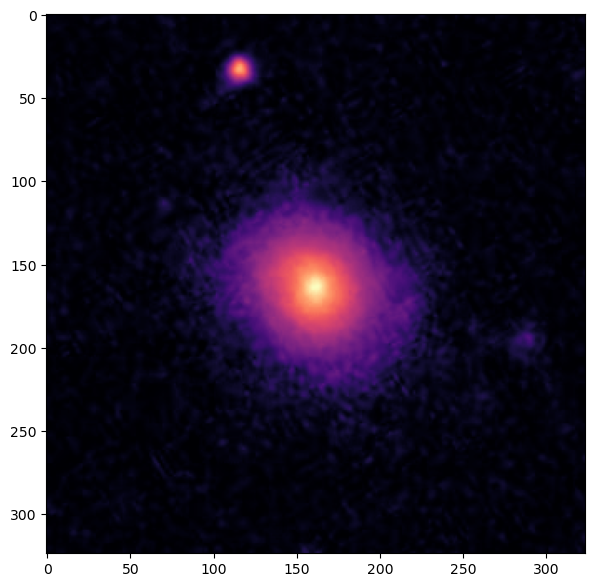

In [20]:
import matplotlib.pyplot as plt
img, lab, indx = DS.__getitem__(0)
#print(lab)
#print(img)         #3D TENSOR    
if DS.rgb:
    fig, ax = plt.subplots(1,3, figsize=(24,7))
    color = ['Reds', 'Greens', 'Blues']
    for i,j in enumerate(img):
        ax[i].imshow(j, cmap=color[i])
else:
    fig, ax = plt.subplots(1,1, figsize=(24,7))
    ax.imshow(img[0], cmap='magma')
#print(img.shape)


## TRAINING + VALIDATION

In [27]:
loss_function = nn.MSELoss()
optimizer = optim.SGD(gnet.parameters(), lr=0.001, momentum=0.9)

In [7]:
def one_epoch_train(verbose=False):
    running_loss = 0
    last_loss = 0
    gnet.train()
    for i, data in enumerate(train_loader):
        inputs,labels, _ = data
        inputs,labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        outputs = gnet(inputs) #, activation=F.relu)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimizer.step() # fa update del parameter
        RMSEloss = np.sqrt(loss.item()) #provare con torch
        running_loss += RMSEloss
        if verbose and i%10 ==0: print(f'Batch {i+1}/{len(train_loader)} - Loss: {RMSEloss:.3f}')

        gnet.log_the_loss(RMSEloss, epoch=False)
        if i == len(train_loader)-1: #se siamo alla fine del ciclo
            epochmean_loss = running_loss / len(train_loader)
            print(f'\nLoss: {epochmean_loss:.3f}')
            gnet.log_the_loss(epochmean_loss, epoch=True)
            last_loss = RMSEloss
            print(f"Last loss: {last_loss:.3f}")
    return last_loss

In [29]:
def one_epoch_eval(verbose=False):
    gnet.eval()
    running_validation_loss = 0.
   
    with torch.no_grad(): # deactivates gradient evaluation
        for i, vdata in enumerate(test_loader):
            inputs,labels, _ = vdata
            inputs,labels= inputs.to(device), labels.to(device)
            outputs = gnet(inputs)#, activation=F.relu)
            loss = loss_function(outputs,labels)
            RMSEloss = np.sqrt(loss.item())
            running_validation_loss +=RMSEloss
            gnet.log_the_loss(RMSEloss,epoch=False)
    mean_vloss=gnet.log_the_loss(RMSEloss/(i+1),epoch=True)
    if verbose: print(f"Validation Loss: {mean_vloss:.3f}\n---")
    return mean_vloss
    

In [37]:
for epoch in range(0,1):
    print(f'Training epoch {epoch}')
    epoch_last_loss = one_epoch_train(verbose=True)
    print(f'End of epoch {epoch} \n---')
    print(f'Evaluation epoch {epoch}')
    epoch_vloss = one_epoch_eval(verbose=True)

[I 2025-05-17 11:02:51,739] A new study created in memory with name: no-name-65661df6-cc2f-4b55-8155-47caac286f6f


Training epoch 0
Batch 1/385 - Loss: 0.433
Batch 11/385 - Loss: 0.430
Batch 21/385 - Loss: 0.435
Batch 31/385 - Loss: 0.435
Batch 41/385 - Loss: 0.430
Batch 51/385 - Loss: 0.432
Batch 61/385 - Loss: 0.436
Batch 71/385 - Loss: 0.431
Batch 81/385 - Loss: 0.431
Batch 91/385 - Loss: 0.429
Batch 101/385 - Loss: 0.431
Batch 111/385 - Loss: 0.433
Batch 121/385 - Loss: 0.435
Batch 131/385 - Loss: 0.430
Batch 141/385 - Loss: 0.433
Batch 151/385 - Loss: 0.433
Batch 161/385 - Loss: 0.433
Batch 171/385 - Loss: 0.433
Batch 181/385 - Loss: 0.432
Batch 191/385 - Loss: 0.432
Batch 201/385 - Loss: 0.431
Batch 211/385 - Loss: 0.430
Batch 221/385 - Loss: 0.434
Batch 231/385 - Loss: 0.431
Batch 241/385 - Loss: 0.435
Batch 251/385 - Loss: 0.430
Batch 261/385 - Loss: 0.432
Batch 271/385 - Loss: 0.430
Batch 281/385 - Loss: 0.429
Batch 291/385 - Loss: 0.432
Batch 301/385 - Loss: 0.434
Batch 311/385 - Loss: 0.433
Batch 321/385 - Loss: 0.434
Batch 331/385 - Loss: 0.432
Batch 341/385 - Loss: 0.433
Batch 351/385 

## OPTUNA


In [ ]:
def objective(trial):
    num_conv_layers = trial.suggest_int("num_conv_layers", 2, 5, 1)
    # qui tuniamo il numero di filtri, per layer più profondi ci vogliono più filtri 
    # (64-28 è consigliato per pattern astratti e combinazioni, mentre fino a 32 per dettagli locali) 
    # quindi proviamo (VGG usa fino a 512 per esempio).
    num_filters = [int(trial.suggest_discrete_uniform("num_filters_"+str(i), 16, 128, 16)) for i in range(num_conv_layers)]
    # abbiamo numneurons1 e numn neurons2,se mettiamo un grid sampler o un random sampler 
    # con num_neurons e basta penso che lui provi diverse combinazioni
    num_neurons = trial.suggest_int("num_neurons",10,200,10) 
    # abbiamo chiamato mode l'activation function nell'initialization dei pesi o la chiamiamo activation
    # così optuna poi inizializza in base a quello.
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu"])
    
    #da capire come inserire.
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"]) #AdamW è suggerito per CNN.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True) #log true cerca i valori in scala logaritmica

    # batch size da tunare?
    # batch_size = trial.suggest_int("batch_size", 16, 128, 16)

    #(self, n_conv_layers, num_filters,num_neurons1, num_neurons2, activation):
    model = GalaxyNet(trial, num_conv_layers, num_filters, num_neurons, num_neurons, activation).to(device)

    